# 豆瓣短评数据分析

## 数据读入

In [283]:
# 导入所需包
import numpy as np
import pandas as pd
import re
import jieba

from pyecharts.charts import Pie, Bar, Map, Line, Page
from pyecharts import options as opts
from pyecharts.globals import SymbolType, WarningType
WarningType.ShowWarning = False

In [284]:
pd.options.display.max_rows = 1000

In [285]:
# 读入数据
df = pd.read_excel('../data/隐秘的角落豆瓣短评6.26.xlsx')
print(df.shape) 
print(df.info())  

(500, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_name      500 non-null    object
 1   page_url       500 non-null    object
 2   rating_num     500 non-null    object
 3   comment_time   500 non-null    object
 4   short_comment  500 non-null    object
 5   votes_num      500 non-null    int64 
 6   city_name      500 non-null    object
dtypes: int64(1), object(6)
memory usage: 27.5+ KB
None


In [286]:
# 删除列
df = df.drop('page_url', axis=1)

# 查看重复值和空值
print(df.duplicated().sum())
print(df.isnull().sum())

0
user_name        0
rating_num       0
comment_time     0
short_comment    0
votes_num        0
city_name        0
dtype: int64


## 数据预处理

1. rating_num: 异常值处理、星级转换
2. comment_time: 时间类型转换
3. short_comment：分词处理
4. city_name：提取城市名

In [287]:
# 定义字典
def transform_rating(x):
    if x == '立荐':
        return '5星'
    elif x == '推荐':
        return '4星'
    elif x == '还行':
        return '3星'
    elif x == '较差':
        return '2星'
    elif x == '很差':
        return '1星'
    else:
        return '5星'  # 异常值使用众数替换

# apply函数
df['rating_num'] = df.rating_num.apply(transform_rating) 
df.rating_num.value_counts() 

5星    272
4星    117
3星     63
2星     38
1星     10
Name: rating_num, dtype: int64

In [288]:
# 城市数据处理
# 国外数据
df['city_name'] = df['city_name'].map(lambda x:'国外' if re.search('[a-zA-Z]', x) else x)

# 处理国内数据
def tranform_city(x):
    if '中国香港' in x:
        return '香港' 
    elif '中国澳门' in x:
        return '澳门' 
    elif '河北' in x:
        return '河北'
    elif '青铜峡' in x:
        return '宁夏'
    elif '江苏' in x:
        return '江苏' 
    elif len(x) == 4 and '中国' not in x:
        return x[:2]
    elif len(x) > 4:
        return x[:3]
    else:
        return x
    
# apply函数
df['city_name'] = df.city_name.apply(tranform_city)

## 数据可视化

### 总体评分分布

In [289]:
rating_num = df.rating_num.value_counts() 
rating_num

5星    272
4星    117
3星     63
2星     38
1星     10
Name: rating_num, dtype: int64

In [290]:
# 数据对
data_pair = [list(z) for z in zip(rating_num.index.tolist(), rating_num.values.tolist())]

# 绘制饼图
pie1 = Pie(init_opts=opts.InitOpts(width='1350px', height='750px'))
pie1.add('', data_pair=data_pair, radius=['35%', '60%'], rosetype='radius')
pie1.set_global_opts(title_opts=opts.TitleOpts(title='总体评分分布'), 
#                      toolbox_opts=opts.ToolboxOpts(),
                     legend_opts=opts.LegendOpts(orient='vertical', pos_top='15%', pos_left='2%'))
pie1.set_series_opts(label_opts=opts.LabelOpts(formatter="{b}:{d}%"))
pie1.set_colors(['#FF7F0E', '#1F77B4', '#2CA02C', '#D62728', '#946C8B'])
pie1.render() 

'C:\\Users\\wzd\\Desktop\\CDA\\CDA_Python\\Python项目实作\\影视视频\\爱奇艺\\隐秘的角落\\code\\render.html'

### 评论时间走势

In [291]:
comment_hour = df.comment_time.str.split(':').str[0]
comment_hour = comment_hour.value_counts().sort_index()
comment_hour[:5] 

2020-06-16 20    20
2020-06-16 21    31
2020-06-16 22    29
2020-06-16 23    17
2020-06-17 00     8
Name: comment_time, dtype: int64

In [292]:
# 选取数据
x_data = [i.replace('2020-','') for i in comment_hour.index]
y_data = comment_hour.values.tolist()

# 折线图
line1 = Line(init_opts=opts.InitOpts(width='1350px', height='750px'))
line1.add_xaxis(x_data)
line1.add_yaxis('', y_data,
                areastyle_opts=opts.AreaStyleOpts(opacity=0.5),
                markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_="max")]),
                label_opts=opts.LabelOpts(is_show=False)
               )
line1.set_global_opts(title_opts=opts.TitleOpts(title='评论数量时间走势图'), 
                      xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate='90')),
                      visualmap_opts=opts.VisualMapOpts(max_=30))
line1.set_series_opts(linestyle_opts=opts.LineStyleOpts(width=3))
line1.render() 

'C:\\Users\\wzd\\Desktop\\CDA\\CDA_Python\\Python项目实作\\影视视频\\爱奇艺\\隐秘的角落\\code\\render.html'

### 评论者Top10城市分布

In [293]:
# 国内城市top10
city_top10 = df['city_name'].value_counts()[:12]
city_top10.drop(['国外', '未知'], inplace=True)
city_top10

北京    132
上海     55
广东     31
江苏     22
四川     20
浙江     12
福建      8
湖北      6
重庆      6
湖南      6
Name: city_name, dtype: int64

In [294]:
# 条形图
bar1 = Bar(init_opts=opts.InitOpts(width='1350px', height='750px'))
bar1.add_xaxis(city_top10.index.tolist())
bar1.add_yaxis("", city_top10.values.tolist())
bar1.set_global_opts(title_opts=opts.TitleOpts(title="评论者Top10城市分布"),
                     visualmap_opts=opts.VisualMapOpts(max_=100),
                    ) 
bar1.render()

'C:\\Users\\wzd\\Desktop\\CDA\\CDA_Python\\Python项目实作\\影视视频\\爱奇艺\\隐秘的角落\\code\\render.html'

### 评论者国内城市分布

In [295]:
city_num = df.city_name.value_counts()
city_num[:5]

北京    132
未知     98
上海     55
国外     55
广东     31
Name: city_name, dtype: int64

In [296]:
# 地图
map1 = Map(init_opts=opts.InitOpts(width='1350px', height='750px'))
map1.add("", [list(z) for z in zip(city_num.index.tolist(), city_num.values.tolist())],
         maptype='china')
map1.set_global_opts(title_opts=opts.TitleOpts(title='评论者国内城市分布'),
                     visualmap_opts=opts.VisualMapOpts(max_=50),
                    ) 
map1.render() 

'C:\\Users\\wzd\\Desktop\\CDA\\CDA_Python\\Python项目实作\\影视视频\\爱奇艺\\隐秘的角落\\code\\render.html'

### 豆瓣六位主演的评价分布

In [298]:
df_sel = df[(df.rating_num=='3星')] 
df_sel.short_comment.str.contains('颂文|朱永平').sum() 

6

In [299]:
people = ['张东升', '朱朝阳', '严良', '普普', '陈冠声', '朱永平']
people_label = ['张东升|东升|秦昊', '朱朝阳|朝阳', '严良', '普普', '景春|陈冠声', '颂文|朱永平']

haoping_num = [133, 78, 28, 29, 25, 31] 
zhongping_num = [11, 4, 3, 4, 2, 6] 
chaping_num = [7, 3, 1, 3, 1, 0] 

people.reverse()
haoping_num.reverse()
zhongping_num.reverse() 
chaping_num.reverse() 
print(people, '\n', haoping_num, '\n', zhongping_num, '\n', chaping_num) 

['朱永平', '陈冠声', '普普', '严良', '朱朝阳', '张东升'] 
 [31, 25, 29, 28, 78, 133] 
 [6, 2, 4, 3, 4, 11] 
 [0, 1, 3, 1, 3, 7]


In [300]:
haoping_perc = []
zhongping_perc = []
chaping_perc = []

for h, z, c in zip(haoping_num, zhongping_num, chaping_num):
    haoping_perc.append(round(h/(h+z+c)*100,2))
    zhongping_perc.append(round(z/(h+z+c)*100,2))
    chaping_perc.append(round(c/(h+z+c)*100,2))   

In [301]:
people_2 = ['张东升', '朱朝阳', '严良', '普普', '陈冠声', '朱永平']
tiji_num = [133+11+7, 78+4+3, 28+3+1, 29+4+3, 25+2+1, 31+6] 

In [304]:
# 条形图
bar2 = Bar(init_opts=opts.InitOpts(width='1350px', height='750px'))
bar2.add_xaxis(people_2)
bar2.add_yaxis('', tiji_num)
bar2.set_global_opts(title_opts=opts.TitleOpts(title='豆瓣评论中提及主演次数'), 
                     visualmap_opts=opts.VisualMapOpts(max_=151))

bar2.render() 

'C:\\Users\\wzd\\Desktop\\CDA\\CDA_Python\\Python项目实作\\影视视频\\爱奇艺\\隐秘的角落\\code\\render.html'

In [305]:
# 条形图
bar3 = Bar(init_opts=opts.InitOpts(width='1350px', height='750px'))
bar3.add_xaxis(people)
bar3.add_yaxis('好评', haoping_perc, stack='stack1')
bar3.add_yaxis('一般', zhongping_perc, stack='stack1')
bar3.add_yaxis('差评', chaping_perc, stack='stack1')
bar3.set_global_opts(title_opts=opts.TitleOpts(title='豆瓣关于6位主演的评价分布'))
bar3.set_series_opts(label_opts=opts.LabelOpts(formatter='{c}%', position='inside'))
bar3.set_colors(['#1F77B4', '#2CA02C', '#D62728'])
bar3.reversal_axis()
bar3.render() 

'C:\\Users\\wzd\\Desktop\\CDA\\CDA_Python\\Python项目实作\\影视视频\\爱奇艺\\隐秘的角落\\code\\render.html'

In [306]:
page1 = Page()
page1.add(pie1, line1, bar1, map1, bar2, bar3) 
page1.render('隐秘的角落豆瓣短评分析.html')

'C:\\Users\\wzd\\Desktop\\CDA\\CDA_Python\\Python项目实作\\影视视频\\爱奇艺\\隐秘的角落\\code\\隐秘的角落豆瓣短评分析.html'

### 评论词云图

In [105]:
import stylecloud
from IPython.display import Image # 用于在jupyter lab中显示本地图片
from collections import Counter

In [148]:
# 定义分词函数
def get_cut_words(content_series):
    # 读入停用词表
    stop_words = [] 
    
    with open(r"C:\Users\wzd\Desktop\CDA\CDA_Python\Python文本分析\10.文本摘要\stop_words.txt", 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            stop_words.append(line.strip())

    # 添加关键词
    my_words = ['秦昊', '张东升', '王景春', '陈冠声', '荣梓杉',
                '朱朝阳', '史彭元', '严良', '王圣迪', '普普',
                '岳普', '张颂文', '朱永平'] 
    
    for i in my_words:
        jieba.add_word(i) 

    # 自定义停用词
    my_stop_words = ['真的', '这部', '这是', '一种']  
    stop_words.extend(my_stop_words)               

    # 分词
    word_num = jieba.lcut(content_series.str.cat(sep='。'), cut_all=False)

    # 条件筛选
    word_num_selected = [i for i in word_num if i not in stop_words and len(i)>=2]
    
    return word_num_selected

In [149]:
# 好评
text1 = get_cut_words(content_series=df.short_comment[(df.rating_num=='5星')|(df.rating_num=='4星')])
text1[:5]  

['笛卡尔', '感情', '失败', '秃子', '追不回']

In [150]:
# 差评
text2 = get_cut_words(content_series=df.short_comment[(df.rating_num=='1星')|(df.rating_num=='2星')])
text2[:5]   

['开头', '上天', '悬念', '不噎', '没头没脑']

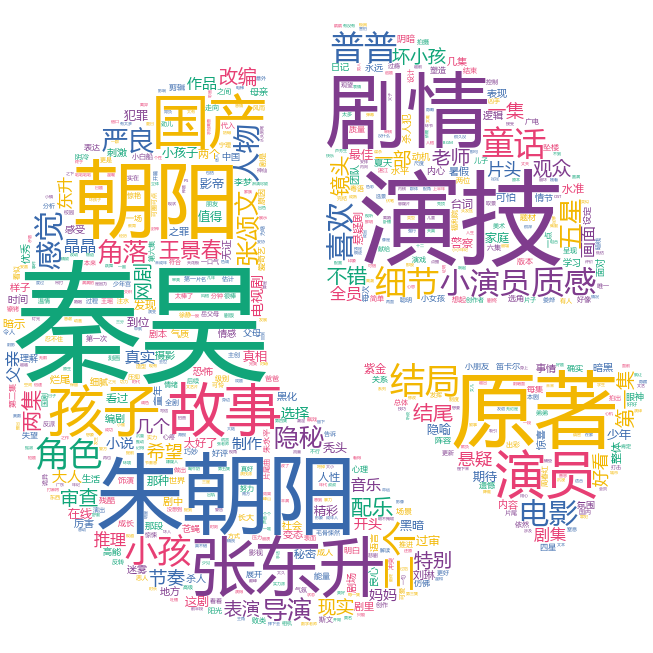

In [151]:
# 绘制词云图
stylecloud.gen_stylecloud(text=' '.join(text1), max_words=1000,
                          collocations=False,
                          font_path=r'‪C:\Windows\Fonts\msyh.ttc',
                          icon_name='fas fa-chart-pie',
                          size=653,
                          output_name='./词云图/隐秘的角落-豆瓣好评.png')
Image(filename='./词云图/隐秘的角落-豆瓣好评.png') 

好评词云图关键词：
1. 剧情/剧本：剧情一环扣一环，剧情的设计感足足的，真的太酷了
2. 演技/演员：秦昊的是影帝级别的演技担当；小演员们演技特别不错；影帝王景春张颂文
3. 选景/配乐/镜头/调色：整个选角选景都太对味了，南方的那种湿热阴冷被表现得淋漓尽致！细节、配乐、调色到位。

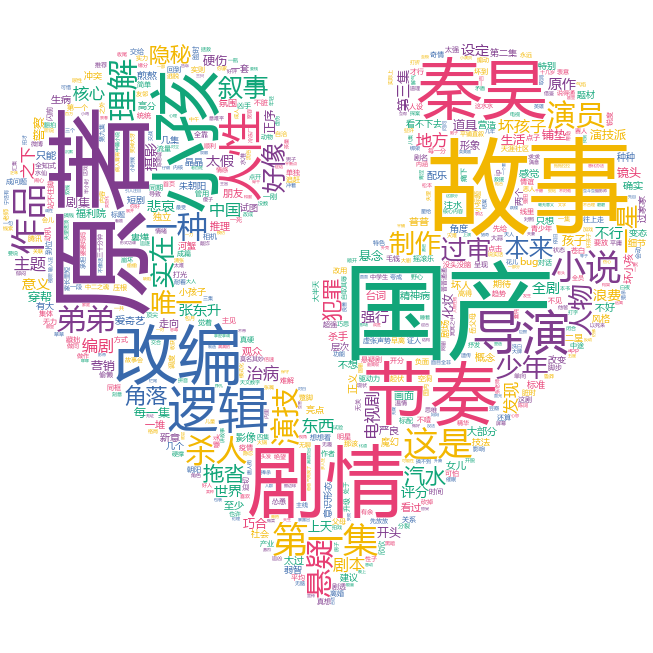

In [147]:
stylecloud.gen_stylecloud(text=' '.join(text2), max_words=1000,
                          collocations=False,
                          font_path=r'‪C:\Windows\Fonts\msyh.ttc',
                          icon_name='fas fa-heart-broken',
                          size=653,
                          output_name='./词云图/隐秘的角落-豆瓣差评.png')
Image(filename='./词云图/隐秘的角落-豆瓣差评.png') 

差评关键词：
1. 原著：将原著最核心的内涵改的面目全非；
2. 故事：故事线的逻辑无法自洽，叙事节奏平铺直叙毫无巧思；
3. 国产：国产剧一贯尿性，有些许亮点，但是总是一堆问题；
4. 剧情：拖沓的剧情和无趣的台词